## Compare Numba and C code

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


import time as time

# -------------- SET UP YOUR PATH ------------
import sys
sys.path.append("~/OneDrive/ExtendedProject/Code/Weak SDE approximation/C++")

import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Visualisation tools 

In [135]:
# function to plot numba results 
def plot_qpnumba(qp,tau,gamma):
    fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(25,8))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    fig.suptitle("$\\tau$="+str(tau)+", $\\gamma=$"+str(gamma)+", $N=$"+str(len(qp[::,0])))

    #Plot 1
    ## position q experiment
    histogram,bins = np.histogram(qp[::,0],bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='q-Experiment')
    ax1.legend() 

    #Plot 2: 
    ### momentum p experiment
    histogram,bins = np.histogram(qp[::,1],bins=100,range=[-1.5,1.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    # histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
    ax2.plot(midx_p,histogram,label='p-Experiment')

    ### position q true
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    ax1.plot(midx_q,rho,'--',label='Truth')
    ax1.legend() 

    ### momentum p true
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx_p,rho,'--',label='Truth')
    ax2.legend() 

    #Plot 3 
    ax3.set_ylim(-5,5)
    ax3.plot(qp[::,1],label="p")
    ax3.plot(qp[::,0],label="q")



    ax3.legend()


### USE THIS TO PLOT C CODE 
def plot_qp(q,p,tau,gamma):
    fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(25,6))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    fig.suptitle("$\\tau$="+str(tau)+", $\\gamma=$"+str(gamma))

    #Plot 1
    ## position q experiment
    histogram,bins = np.histogram(q,bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='q-Experiment')
    ax1.legend() 

    #Plot 2: 
    ### momentum p experiment
    histogram,bins = np.histogram(p,bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    # histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
    ax2.plot(midx_p,histogram,label='p-Experiment')

    ### position q true
    rho = np.exp(- 1/tau*U(midx_q))
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    ax1.plot(midx_q,rho,'--',label='Truth')
    ax1.legend() 

    ### momentum p true
    rho = np.exp(- 1/tau*(midx_p**2)/2)
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx_p,rho,'--',label='Truth')
    ax2.legend() 

    #Plot 3 
    ax3.set_ylim(-5,5)
    ax3.plot(p,label="p")
    ax3.plot(q,label="q")


    ax3.legend()

def U(x):
    res = (0.5/(x*x)+x*x)
    return res

## Compare codes
### Numba code 

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=1
m=0.01
includeD=True # if 1 include divergence term

def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    return gprime

@njit(float64[:](float64[:],float64,float64,float64,float64))
def one_traj_ada(qp,T,dt,gamma,tau):
    t=0
    q=qp[0]
    p=qp[1]
    count=0
    #useful things to compute
    f = -Up(q)
    g=getg(q)
    if includeD==True:
        gp=getgprime(q)
    gdt=g*dt

    while t<T:

        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # step B with extra term in in
        if includeD==True:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=getg(q)
        gdt=dt*g

        p +=0.5*gdt*f 
            # step B with extra term in it
        if includeD==True:
            gp=getgprime(q)
            p += 0.5*dt*tau*gp

        t+= dt #Jonas steps
        # t+=gdt #before

        count+=1
        # print("p")
        # print(p)
        # print("\n q")
        # print(q)
    qp=np.array([q,p])

    return (qp)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,tau,T,h):
    qp_list=np.zeros((n_samples,2))
    qipi = np.array([2.0,0.0]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(n_samples):
        qfpf = one_traj_ada(qipi,T,h,gamma,tau)
        qp_list[j,::]=qfpf
    return(qp_list)

#compile the method
qp = method_baoab_ada(1,1,0.1,0.5,0.01)



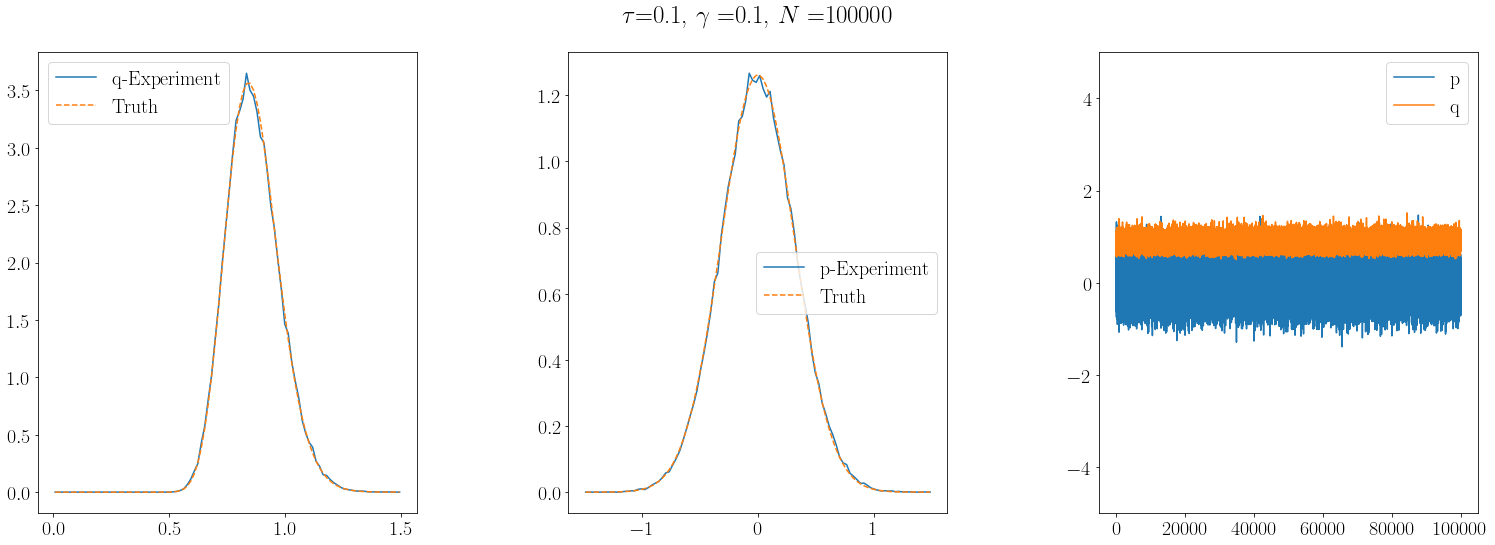

In [154]:

T=500
h = 0.1
gamma = 0.1
tau=0.1
n_samples=100000
Ntimes=int(T*1/h)
qp_ada = method_baoab_ada(n_samples,gamma,tau,T,h)
plot_qpnumba(qp_ada,tau,gamma)

### Import results from Ben's code. CodeBen_revised.c



In [155]:
%run "Python visualisation/upload_txtfile.py"
import pandas as pd

# Read dataset 
mat=openCfile('dat_test')

#Get in into a pandas dataset 
df = pd.DataFrame(mat,columns=["sim","t","Q","P","g","h","Uq","gp"])
final_df=df
qf_list,pf_list,gf_list,hf_list,tf_list,Uqf_list = np.array(final_df["Q"]), np.array(final_df["P"]), np.array(final_df["g"]), np.array(final_df["h"]), np.array(final_df["t"]),np.array(final_df["Uq"])



<Figure size 432x288 with 0 Axes>

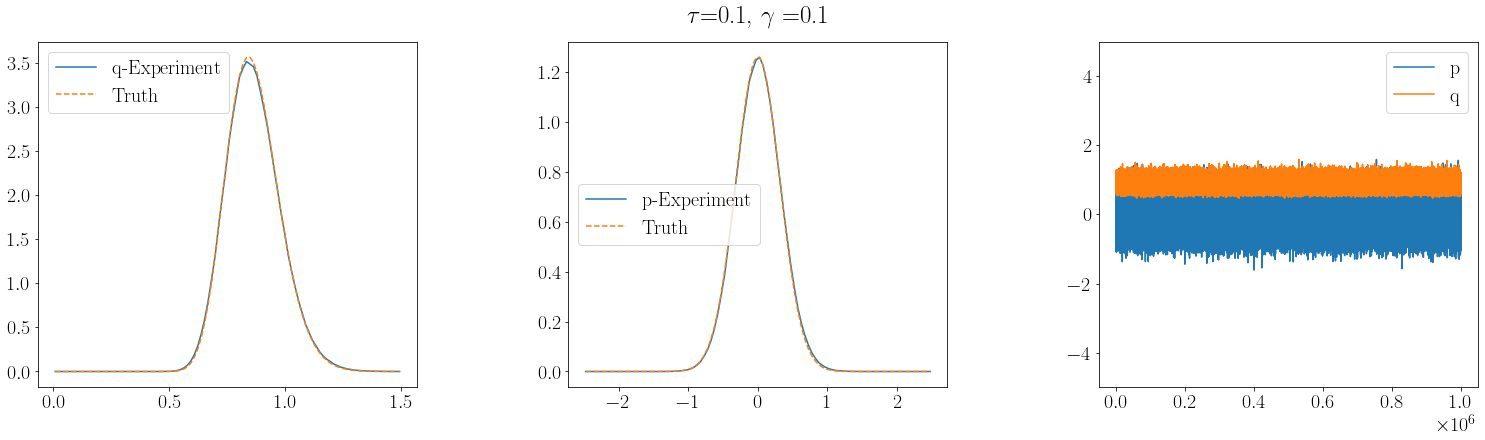

In [158]:
tau=0.1
gamma=0.1
plot_qp(qf_list,pf_list,tau,gamma)

### Compare results from codes


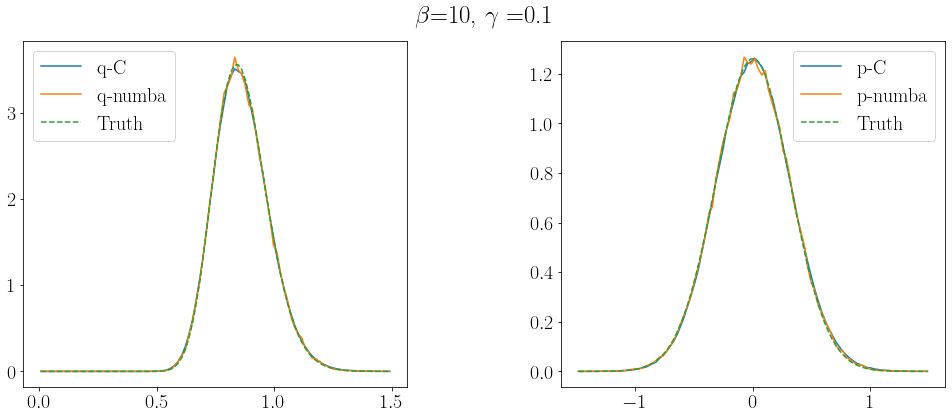

In [159]:
fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(beta)+", $\\gamma=$"+str(gamma))

#Plot 1
## position q experiment - C CODE
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='q-C')
ax1.legend() 

## position q experiment - Numba
histogram,bins = np.histogram(qp_ada[::,0],bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='q-numba')
ax1.legend() 

#Plot 2: 
### momentum p experiment C CODE
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
# histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
ax2.plot(midx_p,histogram,label='p-C')

#Plot 2: 
### momentum p experiment NUMBA CODE
histogram,bins = np.histogram(qp_ada[::,1],bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
# histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
ax2.plot(midx_p,histogram,label='p-numba')

### position q true
rho = np.exp(- beta*U(midx_q))
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Truth')
ax1.legend() 

### momentum p true
rho = np.exp(- beta*(midx_p**2)/2)
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='Truth')
ax2.legend() 


same results - we are very happy now

In [ ]:
## Below is a code to read the version of the data with extensive
# info (save all iterations of all run)
# %run "Python visualisation/upload_txtfile.py"
# import pandas as pd

# # Read dataset 
# mat=openCfile('dat_test')
# #Get in into a pandas dataset 
# df = pd.DataFrame(mat,columns=["sim","t","Q","P","g","h","Uq","gp"])
# # Create a dataset with only the final time
# idx = df.groupby(['sim'])['t'].transform(max) == df['t'] #Get the indexes of the final time
# final_df=df[idx] #Select only dataset with final time
# # Get numpy arrays of the final values 
# qf_list,pf_list,gf_list,hf_list,tf_list,Uqf_list = np.array(final_df["Q"]), np.array(final_df["P"]), np.array(final_df["g"]), np.array(final_df["h"]), np.array(final_df["t"]),np.array(final_df["Uq"])

# ## Plot info on the data produced by Ben's code
# fig, ((ax1,ax2,ax3,ax4))= plt.subplots(1,4,figsize=(20,7))# plt.figure(figsize=(4,4))
# fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# ######## Histograms of the final time achieved #######################
# nbins=100
# var = tf_list
# upperbound = max(var)
# max_range=max(var)
# min_range=min(var)
# histogram,bins = np.histogram(var,bins=nbins,range=[min_range,max_range], density=True)
# midx = (bins[0:-1]+bins[1:])/2
# ax1.bar(midx,histogram,width=(max_range-min_range)/nbins,label="t",color="blue",alpha=0.5)
# ax1.legend()
# ax1.set_title("Histogram of final time")

# ######## Histograms of time steps achieved #######################
# var = hf_list
# upperbound = max(var)
# max_range=max(var)
# min_range=min(var)
# histogram,bins = np.histogram(var,bins=nbins,range=[min_range,max_range], density=True)
# midx = (bins[0:-1]+bins[1:])/2
# ax2.bar(midx,histogram,width=(max_range-min_range)/nbins,label="h",color="blue",alpha=0.5)
# ax2.legend()
# ax2.set_title("Histogram of final time steps")

# ######## Histograms of final values of g(x) #######################
# var = gf_list
# upperbound = max(var)
# max_range=2
# min_range=min(var)
# histogram,bins = np.histogram(var,bins=nbins,range=[min_range,max_range], density=True)
# midx = (bins[0:-1]+bins[1:])/2
# ax3.bar(midx,histogram,width=(max_range-min_range)/nbins,label="g",color="blue",alpha=0.5)
# ax3.legend()
# ax3.set_title("Histogram of final values of g")

# ######## Histograms of final values of Uq #######################
# var = Uqf_list
# upperbound = max(var)
# max_range=2
# min_range=min(var)
# histogram,bins = np.histogram(var,bins=nbins,range=[min_range,max_range], density=True)
# midx = (bins[0:-1]+bins[1:])/2
# ax4.bar(midx,histogram,width=(max_range-min_range)/nbins,color="blue",label="Uq",alpha=0.5)
# ax4.legend()
# ax4.set_title("Histogram of final values of Uq")